# Analiza wyników i danych dotyczących wyborów prezydenckich w 2020 roku w USA

## 1. Użyte biblioteki

In [104]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
#import mplcursors
import plotly.io as pio


In [ ]:
# Poprawne generowanie html-a
pio.renderers.default = "notebook_connected"

## 2. Dane

In [ ]:
# Wczytanie danych o wyborach 2020
dane = pd.read_csv("US_Election_dataset_v1.csv", sep=',')
print(dane.dtypes)

full_name                                                                     object
county                                                                        object
state                                                                         object
2020 Democrat vote raw                                                         int64
2020 Democrat vote %                                                         float64
2020 Republican vote raw                                                       int64
2020 Republican vote %                                                       float64
2020 other vote raw                                                            int64
2020 other vote %                                                            float64
Population with less than 9th grade education                                 object
Population with 9th to 12th grade education, no diploma                       object
High School graduate and equivalent                              

In [133]:
dane.head()

,full_name,county,state,2020 Democrat vote raw,2020 Democrat vote %,2020 Republican vote raw,2020 Republican vote %,2020 other vote raw,2020 other vote %,Population with less than 9th grade education,...,NH-Asian percentage,NH-Native Hawaiian and Other Pacific Islander percentage,NH-Some Other Race percentage,NH-Two or More Races percentage,"Percentage engaged in Management, business, science, and arts occupations",Percentage engaged in Service Occupations,Percentage engaged in Sales and Office,Percentage engaged in Resources and Construction,Percentage engaged in Transportation,High Education
0,"Autauga County, Alabama",Autauga County,Alabama,7503,27.02,19838,71.44,429,1.54,1.7,...,1.48,0.04,0.31,4.23,36.39,14.24,22.02,9.99,17.36,True
1,"Baldwin County, Alabama",Baldwin County,Alabama,24578,22.41,83544,76.17,1557,1.42,2.0,...,0.88,0.05,0.33,4.47,35.62,17.14,24.20,9.91,13.13,True
2,"Barbour County, Alabama",Barbour County,Alabama,4816,45.79,5622,53.45,80,0.76,7.3,...,0.41,0.00,0.25,2.19,27.73,20.16,19.49,12.53,20.09,False
3,"Bibb County, Alabama",Bibb County,Alabama,1986,20.70,7525,78.43,84,0.88,6.4,...,0.12,0.04,0.21,2.69,22.22,15.32,20.57,16.43,25.47,False
4,"Blount County, Alabama",Blount County,Alabama,2640,9.57,24711,89.57,237,0.86,7.1,...,0.29,0.02,0.17,3.89,26.75,12.98,22.73,15.81,21.73,False


In [107]:
# Usunięcie znaku '%' i konwersja na liczby zmiennoprzecinkowe
kolumny_edukacja = [
    'Population with less than 9th grade education',
    'Population with 9th to 12th grade education, no diploma',
    'High School graduate and equivalent',
    'Some College,No Degree',
    'Associates Degree',
    'Bachelors Degree',
    'Graduate or professional degree'
]

for kolumna in kolumny_edukacja:
    dane[kolumna] = dane[kolumna].str.replace('%', '').astype(float)

In [108]:
# Wybranie kluczowych kolumn do analizy korelacji
kolumny_korelacja = kolumny_edukacja + [
    '2020 Democrat vote %',
    '2020 Republican vote %',
    '2020 other vote %'
]

# Obliczenie macierzy korelacji
korelacja = dane[kolumny_korelacja].corr()
#print(korelacja)

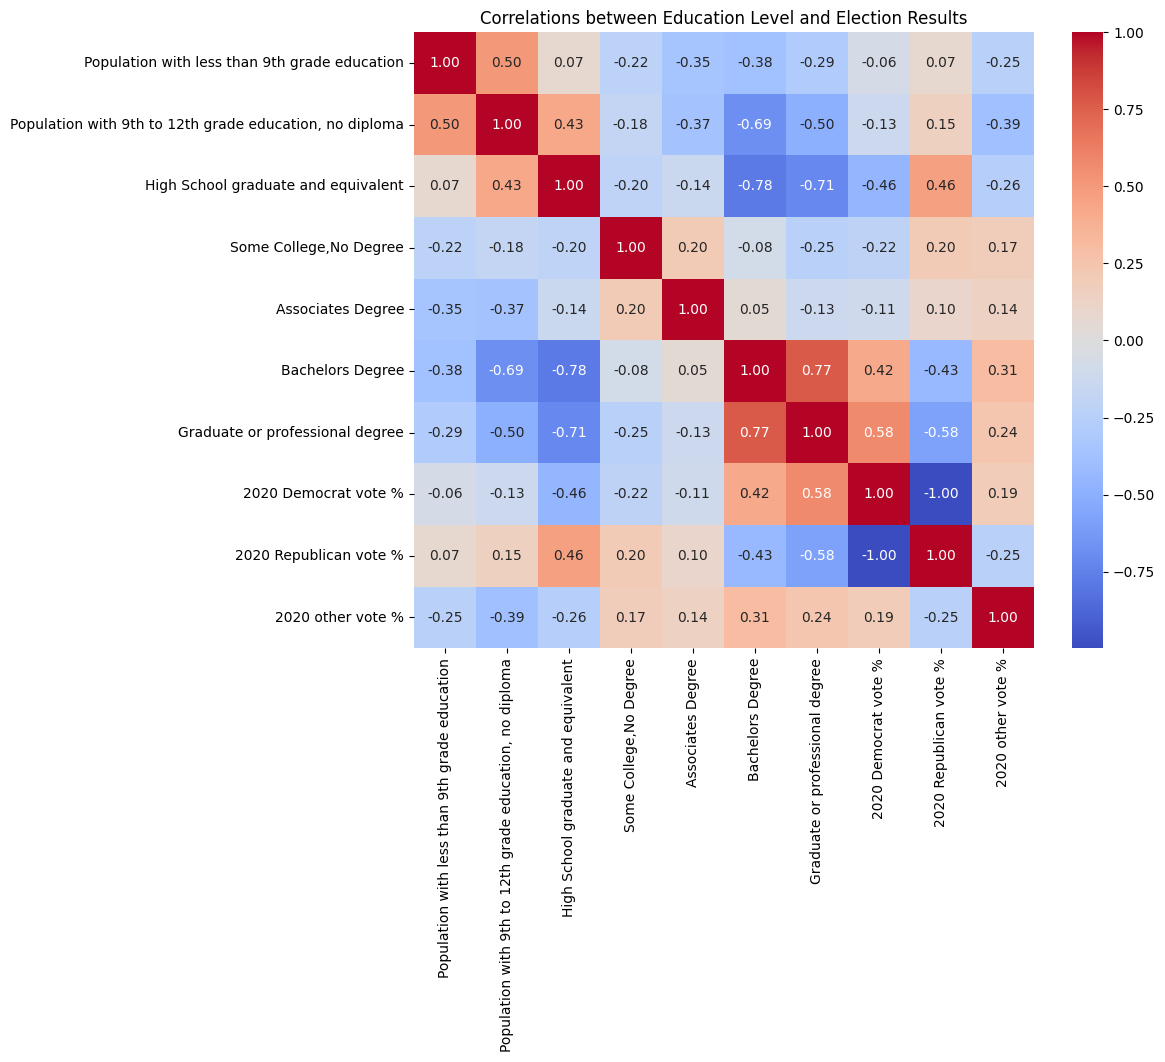

In [109]:
# Wykres korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(korelacja, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlations between Education Level and Election Results")
plt.show()


#### Na wykresie można łatwo zauważyć korelacją pomiędzy wykształceniem a poparciem dla danej partii. Dodatnia korelacja występuje pomiędzy niższym wykształceniem a poparciem dla partii Republikańskiej oraz wyższym wykształceniem a poparciem dla partii demokratycznej. Epicentrum trendu występuje dla wykształcenia średniego (-0,46, 0,46). Na niższych stopniach wykształcenia dominuje poparcie dla republikanów, natomiast osoby o wyższym wykształceniu preferują republikanów. 
#### Najwyższa różnica występuje dla osób z wyższym wykształceniem od 2 stopnia. Współczynnik korelacji wynosi w tym miejscu kolejno 0,58 i -0,58 dla demokratów i republikanów. Ocenia się to jako umiarkowaną korelację. 
#### Inne partie miały największe poparcie wśród osób z wykształceniem wyższym 1 stopnia (inżynier, licencjat) - 0.31.
#### Podsumuwując wykształcenie może być dobrym predytkorem preferencji

In [110]:
# Podział na grupy: wysoki odsetek wykształcenia wyższego
progi = dane['Bachelors Degree'].median()  
dane['High Education'] = dane['Bachelors Degree'] > progi

# Średnie wyniki wyborcze w grupach
srednie_wyniki = dane.groupby('High Education')[['2020 Democrat vote %', '2020 Republican vote %', '2020 other vote %']].mean()
print(srednie_wyniki)

                2020 Democrat vote %  2020 Republican vote %  \
High Education                                                 
False                      29.003848               69.449156   
True                       37.849668               60.104898   

                2020 other vote %  
High Education                     
False                    1.547041  
True                     2.043584  


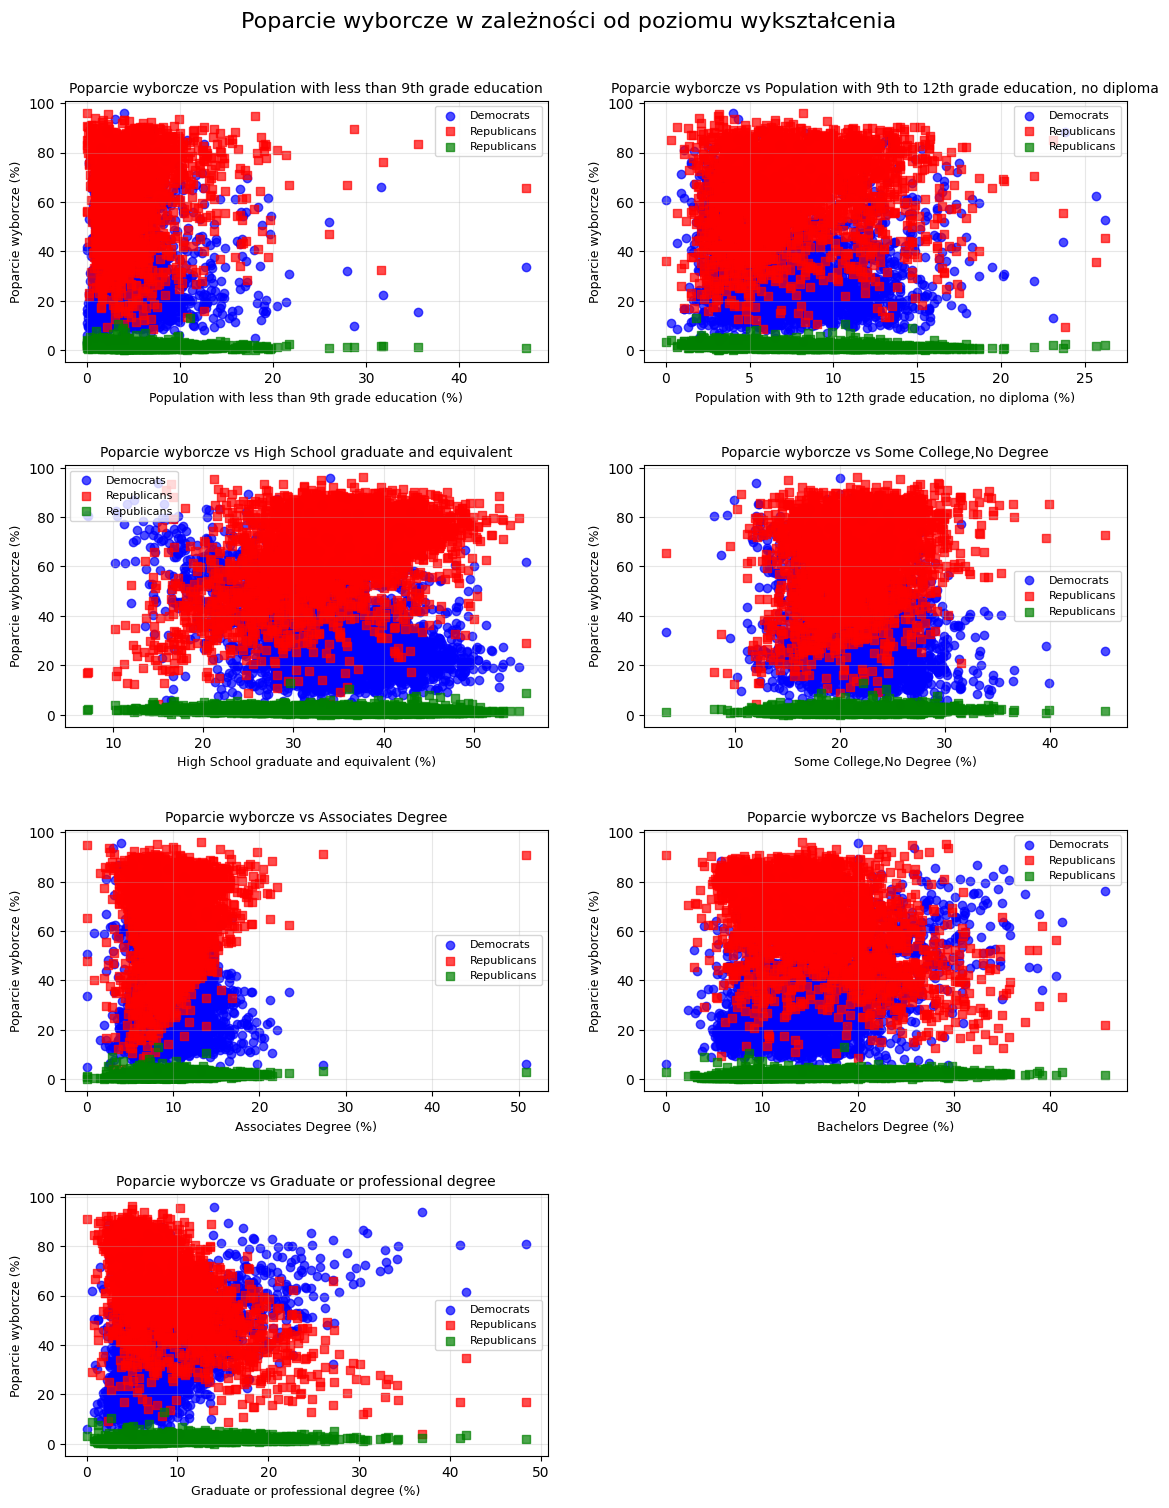

In [111]:
plt.figure(figsize=(12, 15))  # Zmiana wielkości figury na bardziej wydłużoną

# Kolory i style markerów
kolory = ['blue', 'red', 'green']
markery = ['o', 's', 's']

# Liczba wierszy i kolumn
liczba_wierszy = 4
liczba_kolumn = 2

# Tworzenie wykresów dla każdego poziomu edukacji
for i, kolumna in enumerate(kolumny_edukacja):
    plt.subplot(liczba_wierszy, liczba_kolumn, i + 1)  # Siatka z 2 kolumnami
    plt.scatter(dane[kolumna], dane['2020 Democrat vote %'], color=kolory[0], marker=markery[0], alpha=0.7, label='Democrats')
    plt.scatter(dane[kolumna], dane['2020 Republican vote %'], color=kolory[1], marker=markery[1], alpha=0.7, label='Republicans')
    plt.scatter(dane[kolumna], dane['2020 other vote %'], color=kolory[2], marker=markery[2], alpha=0.7, label='Republicans')

    # Dodanie tytułu i etykiet
    plt.title(f'Poparcie wyborcze vs {kolumna}', fontsize=10)
    plt.xlabel(f'{kolumna} (%)', fontsize=9)
    plt.ylabel('Poparcie wyborcze (%)', fontsize=9)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)

plt.tight_layout(pad=3.0)  # Większe odstępy między wykresami
plt.suptitle('Poparcie wyborcze w zależności od poziomu wykształcenia', fontsize=16, y=1.02)
plt.show()


In [112]:
# dane_srednie = dane.groupby('state').mean(numeric_only=True).reset_index()
# plt.figure(figsize=(12, 15))  # Zmiana wielkości figury na bardziej wydłużoną

# # Tworzenie wykresów dla każdego poziomu edukacji
# for i, kolumna in enumerate(kolumny_edukacja):
#     plt.subplot(4, 2, i + 1)  # Siatka z 2 kolumnami
#     plt.scatter(dane_srednie[kolumna], dane_srednie['2020 Democrat vote %'], color='blue', marker='o', alpha=0.7, label='Democrats')
#     plt.scatter(dane_srednie[kolumna], dane_srednie['2020 Republican vote %'], color='red', marker='s', alpha=0.7, label='Republicans')
    
#     # Dodanie tytułu i etykiet
#     plt.title(f'Electoral support vs {kolumna}', fontsize=10)
#     plt.xlabel(f'{kolumna} (%)', fontsize=9)
#     plt.ylabel('Electoral support (%)', fontsize=9)
#     plt.grid(alpha=0.3)
#     plt.legend(fontsize=8)

# plt.tight_layout(pad=3.0)  # Większe odstępy między wykresami
# plt.suptitle("Electoral support depending on education level for all states", fontsize=16, y=1.02)
# plt.show()

In [113]:
dane_srednie = dane.groupby('state').mean(numeric_only=True).reset_index()

# Iteracja po kolumnach edukacji i tworzenie wykresów interaktywnych
for kolumna in kolumny_edukacja:
    fig = px.scatter(
        dane_srednie,
        x=kolumna,
        y=['2020 Democrat vote %', '2020 Republican vote %', '2020 other vote %'],
        labels={kolumna: f'{kolumna} (%)', 'value': 'Electoral support (%)'},
        title=f'Electoral support vs {kolumna}',
        hover_data=['state'],  # Dodanie nazwy stanu do podpowiedzi
    )
    fig.show()

In [114]:
# Wczytanie danych do mapy
dane2 = pd.read_csv("1976-2020-president.csv", sep=';')
#dane2

In [115]:
# Wyciągnięcie danych z 2020 roku
dane_2020 = dane2[dane2.iloc[:, 0] == 2020]
#dane_2020

In [116]:
# Wczytanie mapy USA
usa = gpd.read_file("ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp")
#usa

In [117]:
# Wybieranie wiersz z maksymalną liczbą głosów (candidatevotes) dla każdego stanu
max_votes_per_state = dane_2020.loc[dane_2020.groupby('state')['candidatevotes'].idxmax()]
#print(max_votes_per_state)

In [118]:
# Oczyszczanie nazw stanów (usuwanie zbędnych spacji i konwersja na wielkie litery)
usa['name'] = usa['name'].str.strip().str.upper()
max_votes_per_state['state'] = max_votes_per_state['state'].str.strip().str.upper()

# Złączenie danych
map_data = usa.set_index('name').join(max_votes_per_state.set_index('state'))

# Sprawdzenie wyników
#print(map_data)


In [119]:
# Złączenie tabel
map_data = usa.set_index('name').join(max_votes_per_state.set_index('state'))

In [120]:
candidate_colors = {
    'BIDEN, JOSEPH R. JR': '#1f77b4',  
    'TRUMP, DONALD J.': '#d62728',     
    'Other': '#7f7f7f'                 
}


In [121]:
# Dodanie koloru na podstawie zwycięzcy
map_data['color'] = map_data['candidate'].map(candidate_colors)

In [122]:
map_data["name"] = [
    "MINNESOTA", "MONTANA", "NORTH DAKOTA", "HAWAII", "IDAHO",
    "WASHINGTON", "ARIZONA", "CALIFORNIA", "COLORADO", "NEVADA",
    "NEW MEXICO", "OREGON", "UTAH", "WYOMING", "ARKANSAS",
    "IOWA", "KANSAS", "MISSOURI", "NEBRASKA", "OKLAHOMA",
    "SOUTH DAKOTA", "LOUISIANA", "TEXAS", "CONNECTICUT", "MASSACHUSETTS",
    "NEW HAMPSHIRE", "RHODE ISLAND", "VERMONT", "ALABAMA", "FLORIDA",
    "GEORGIA", "MISSISSIPPI", "SOUTH CAROLINA", "ILLINOIS", "INDIANA",
    "KENTUCKY", "NORTH CAROLINA", "OHIO", "TENNESSEE", "VIRGINIA",
    "WISCONSIN", "WEST VIRGINIA", "DELAWARE", "DISTRICT OF COLUMBIA",
    "MARYLAND", "NEW JERSEY", "NEW YORK", "PENNSYLVANIA", "MAINE",
    "MICHIGAN", "ALASKA"
]

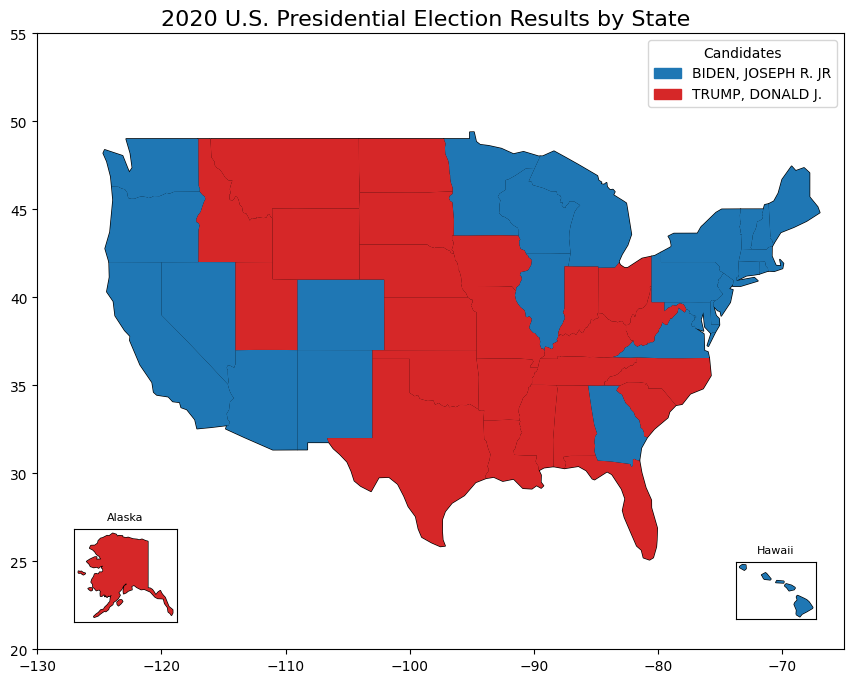

In [123]:
# Główna mapa (kontynentalne USA)
fig, ax = plt.subplots(figsize=(12, 8))
usa.plot(ax=ax, color='lightgrey', edgecolor='black')
map_data.plot(ax=ax, color=map_data['color'])
ax.set_xlim([-130, -65])  # Zakres dla kontynentalnych USA
ax.set_ylim([20, 55])

# Tytuł główny mapy na środku
fig.suptitle('2020 U.S. Presidential Election Results by State', fontsize=16, ha='center', y=0.91)

# Dodanie Alaski w okienku
ax_alaska = inset_axes(ax, width="15%", height="15%", loc='lower left', borderpad=2)
alaska = usa[usa['name'] == 'ALASKA']  
alaska_data = map_data[map_data.iloc[:, 3] == 3563]
alaska.plot(ax=ax_alaska, color='lightgrey', edgecolor='black')
alaska_data.plot(ax=ax_alaska, color=alaska_data['color'])
ax_alaska.set_xticks([])
ax_alaska.set_yticks([])
ax_alaska.set_title("Alaska", fontsize=8)

# Dodanie Hawajów w okienku
ax_hawaii = inset_axes(ax, width="10%", height="10%", loc='lower right', borderpad=2)
hawaii = usa[usa['name'] == 'HAWAII']  
hawaii_data = map_data[map_data.iloc[:, 3] == 3517]  
hawaii.plot(ax=ax_hawaii, color='lightgrey', edgecolor='black')
hawaii_data.plot(ax=ax_hawaii, color=hawaii_data['color'])
ax_hawaii.set_xticks([])
ax_hawaii.set_yticks([])
ax_hawaii.set_title("Hawaii", fontsize=8)

# Wyciągnięcie unikalnych kolorów i odpowiadających im etykiet z danych mapy
unique_colors = map_data[['color', 'candidate']].drop_duplicates()

# Tworzenie elementów legendy na podstawie unikalnych wartości
legend_elements = [
    mpatches.Patch(color=row['color'], label=row['candidate'])
    for _, row in unique_colors.iterrows()
]

# Dodanie legendy
ax.legend(handles=legend_elements, title="Candidates", loc='upper right')

# Wyświetlenie mapy
plt.show()


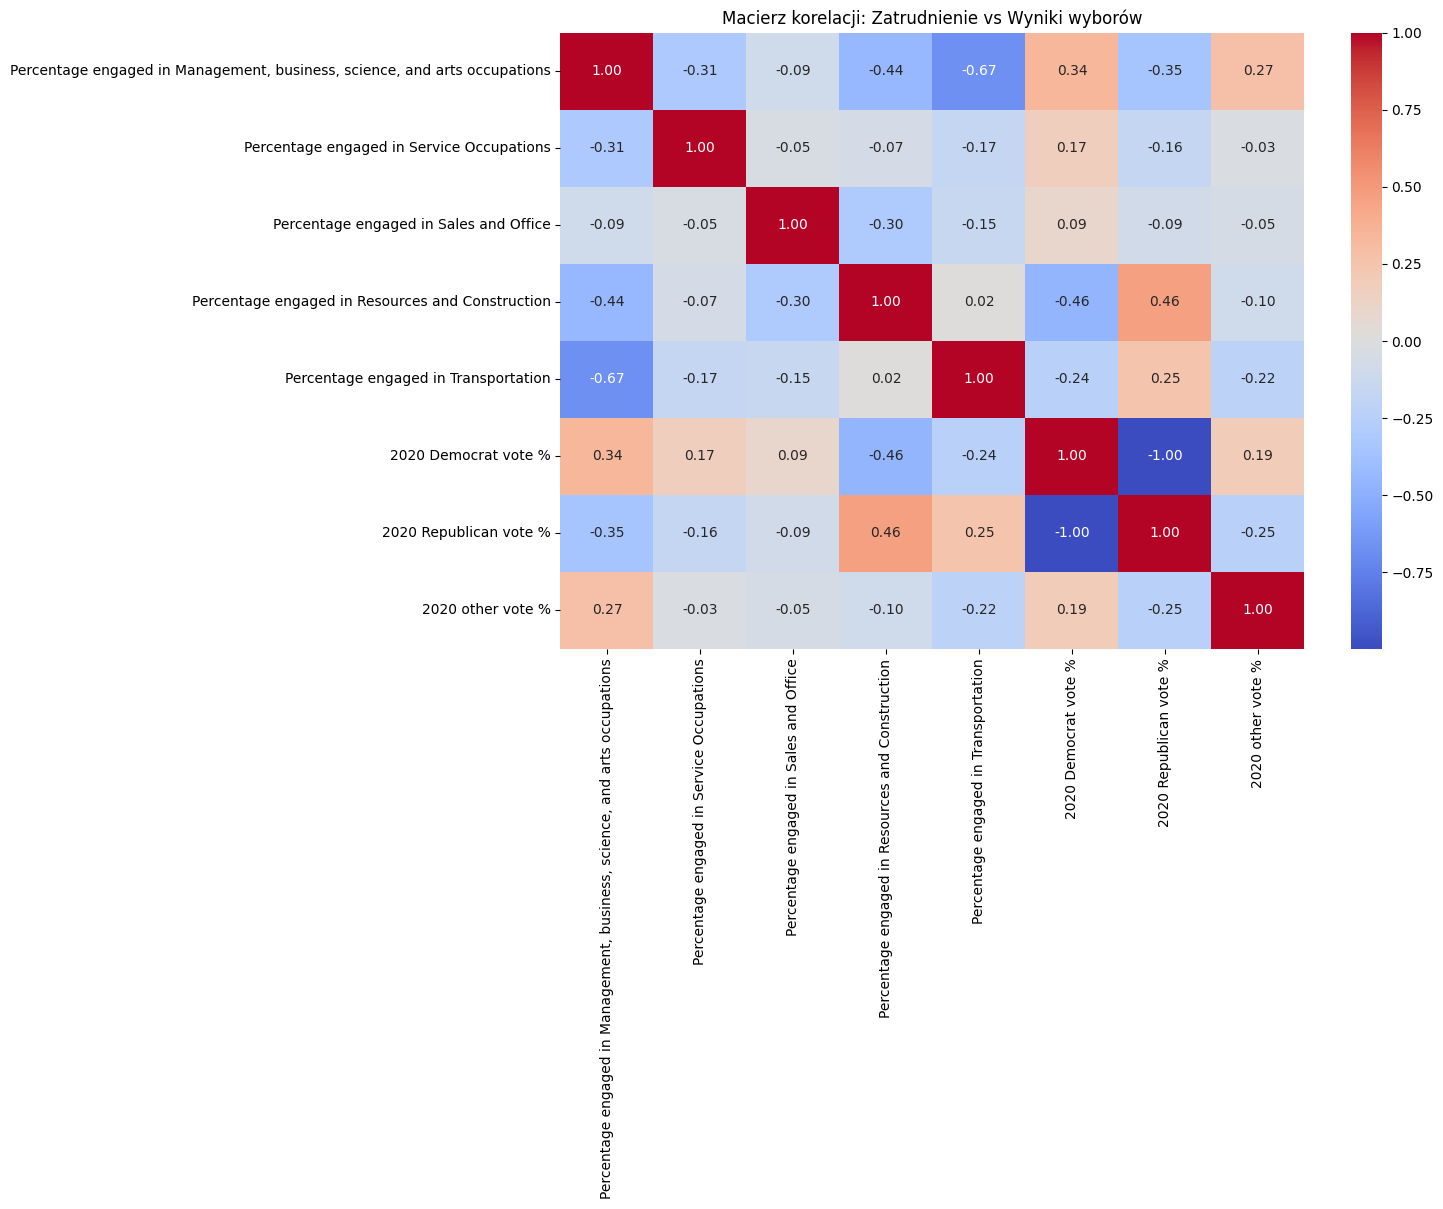

In [124]:
# Kolumny związane z zatrudnieniem
kolumny_zatrudnienie = [
    'Percentage engaged in Management, business, science, and arts occupations',
    'Percentage engaged in Service Occupations',
    'Percentage engaged in Sales and Office',
    'Percentage engaged in Resources and Construction',
    'Percentage engaged in Transportation'
]

# Wyniki wyborów
kolumny_wyniki = [
    '2020 Democrat vote %',
    '2020 Republican vote %',
    '2020 other vote %'
]

# Tworzenie macierzy korelacji dla sektorów zatrudnienia i wyników wyborów
data_korelacja = dane[kolumny_zatrudnienie + kolumny_wyniki]
korelacja_zatrudnienie = data_korelacja.corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(12, 8))
sns.heatmap(korelacja_zatrudnienie, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji: Zatrudnienie vs Wyniki wyborów")
plt.show()



In [125]:
# Grupowanie danych po stanie i obliczanie średnich wartości
dane_srednie = dane.groupby('state').mean(numeric_only=True).reset_index()

# Iteracja po kolumnach zatrudnienia i tworzenie wykresów interaktywnych
for sektor in kolumny_zatrudnienie:
    fig = px.scatter(
        dane_srednie,
        x=sektor,
        y=kolumny_wyniki,  # Kolumny z wynikami wyborczymi
        labels={
            sektor: f'{sektor} (%)',
            'value': 'Electoral support (%)'
        },
        title=f'Electoral support by Employment Sector: {sektor}',
        hover_data=['state'],  # Dodanie informacji o stanie
    )
    fig.show()

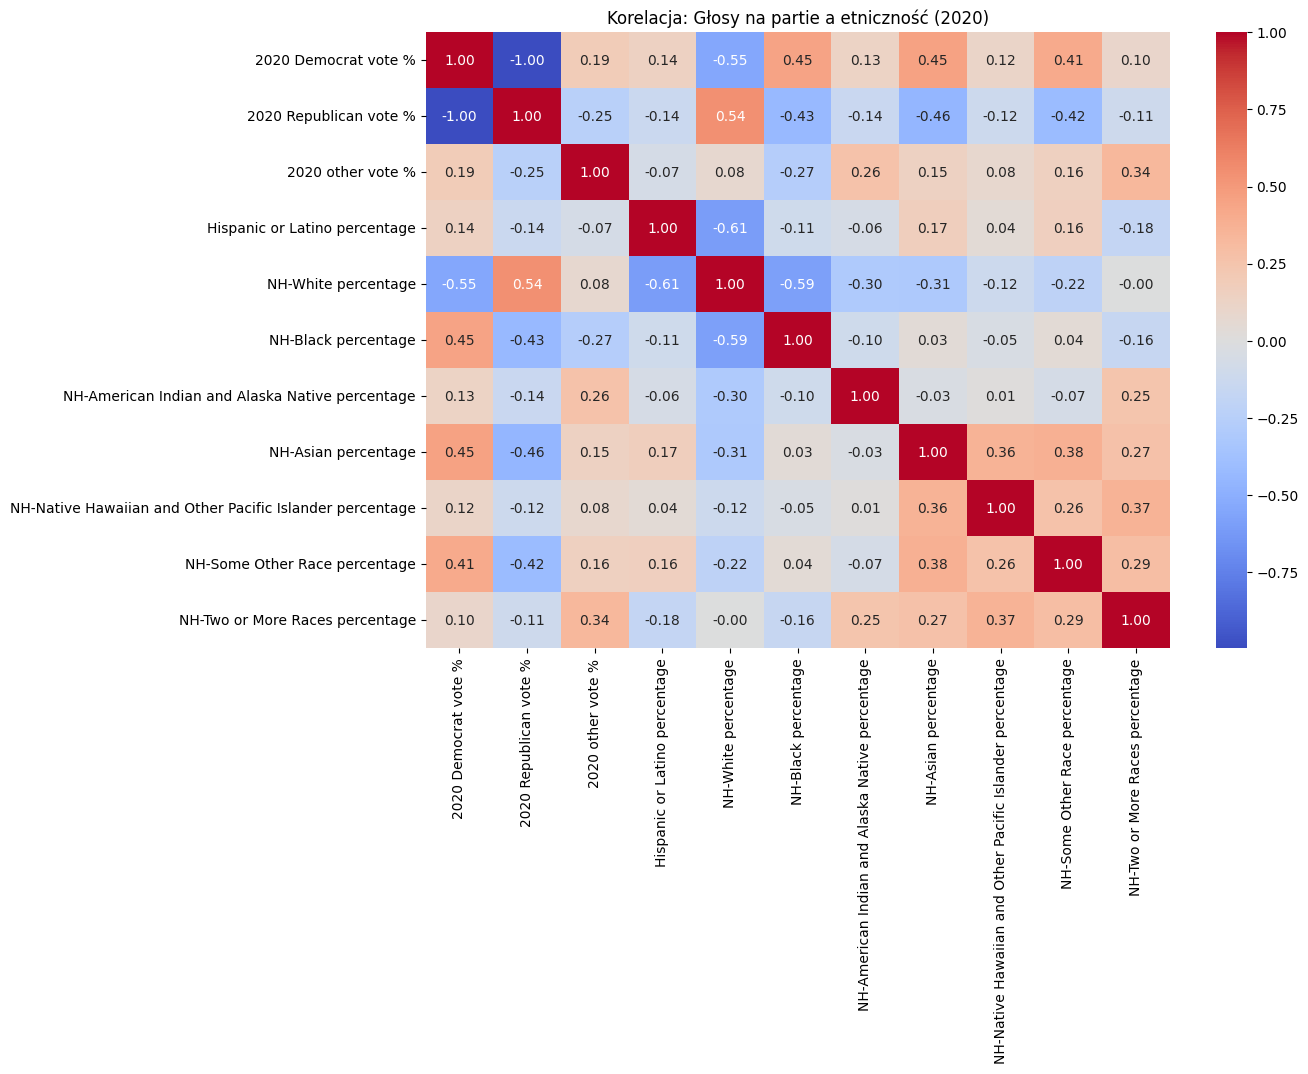

In [126]:
votes_columns = ['2020 Democrat vote %', '2020 Republican vote %', '2020 other vote %']
ethnicity_columns = [
    'Hispanic or Latino percentage',
    'NH-White percentage',
    'NH-Black percentage',
    'NH-American Indian and Alaska Native percentage',
    'NH-Asian percentage',
    'NH-Native Hawaiian and Other Pacific Islander percentage',
    'NH-Some Other Race percentage',
    'NH-Two or More Races percentage'
]

# Konwersja wartości procentowych na liczby (jeśli są w formie string z %)
for column in ethnicity_columns:
    if dane[column].dtype == 'object':
        dane[column] = dane[column].str.replace('%', '').astype(float)

# Łączenie danych głosów i etniczności
correlation_data = dane[votes_columns + ethnicity_columns]

# Obliczanie macierzy korelacji
correlation_matrix = correlation_data.corr()

# Wyświetlenie macierzy korelacji
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelacja: Głosy na partie a etniczność (2020)")
plt.show()

# Wyodrębnienie korelacji dla głosów na partie
#votes_ethnicity_correlation = correlation_matrix.loc[votes_columns, ethnicity_columns]
#print("Korelacja między głosami a etnicznością:")
#rint(votes_ethnicity_correlation)

In [127]:
# Iteracja po kolumnach zatrudnienia i tworzenie wykresów interaktywnych
for etn in ethnicity_columns:
    fig = px.scatter(
        dane_srednie,
        x=etn,
        y=kolumny_wyniki,  # Kolumny z wynikami wyborczymi
        labels={
            etn: f'{etn} (%)',
            'value': 'Electoral support (%)'
        },
        title=f'Electoral support by Etjnicity: {etn}',
        hover_data=['state'],  # Dodanie informacji o stanie
    )
    fig.show()

<>:7: SyntaxWarning:

invalid escape sequence '\d'

<>:7: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\dlacz\AppData\Local\Temp\ipykernel_6080\1138359502.py:7: SyntaxWarning:

invalid escape sequence '\d'



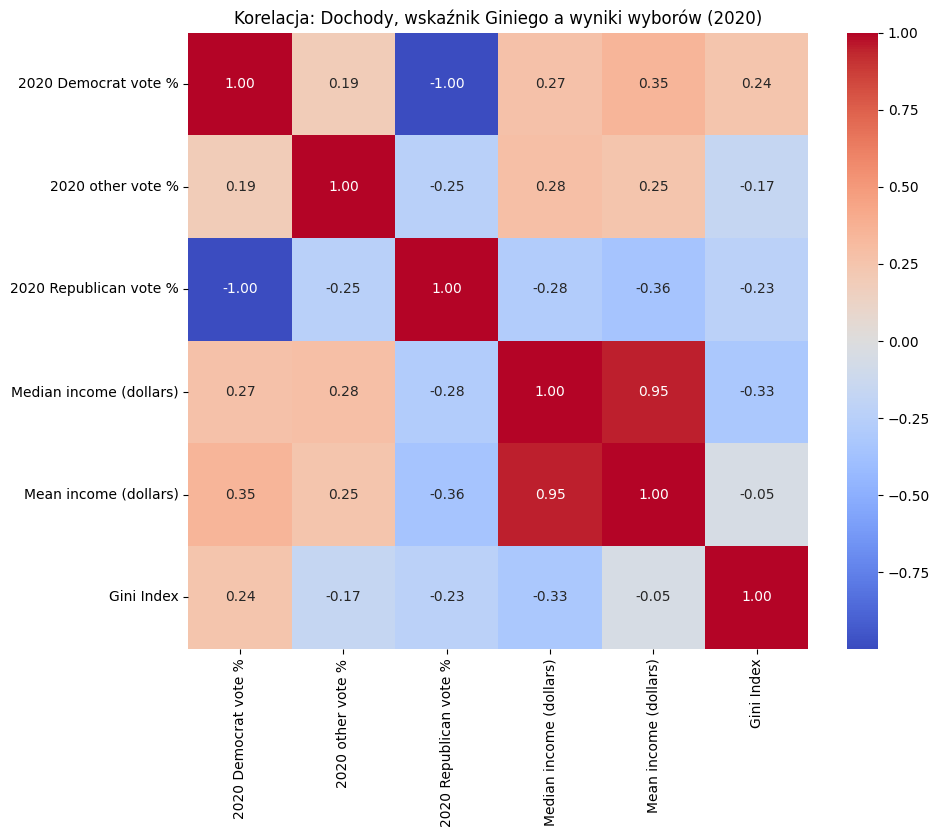

In [128]:
columns_to_convert = ['Median income (dollars)', 'Mean income (dollars)', 'Gini Index']

# Czyszczenie i konwersja danych
for column in columns_to_convert:
    if dane[column].dtype == 'object':
        # Usuwanie przecinków, wyodrębnianie liczb, konwersja na float
        dane[column] = dane[column].str.replace(',', '').str.extract('(\d+\.?\d*)')[0]
        dane[column] = dane[column].astype(float)

# Wypełnienie brakujących wartości, jeśli występują
dane[columns_to_convert] = dane[columns_to_convert].fillna(dane[columns_to_convert].mean())



# Wybór kolumn do analizy
analysis_columns = [
    '2020 Democrat vote %',
    '2020 other vote %',
    '2020 Republican vote %',
    'Median income (dollars)',
    'Mean income (dollars)',
    'Gini Index'
]
analysis_data = dane[analysis_columns]

# Obliczanie macierzy korelacji
correlation_matrix = analysis_data.corr()

# Wyświetlenie macierzy korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelacja: Dochody, wskaźnik Giniego a wyniki wyborów (2020)")
plt.show()


In [129]:
# Grupowanie danych po stanie i obliczanie średnich wartości
dane_srednie = dane.groupby('state').mean(numeric_only=True).reset_index()
# Analiza wpływu medianowego dochodu na wyniki (interaktywny wykres)
fig_income = px.scatter(
    dane_srednie,
    x='Median income (dollars)',
    y=['2020 Democrat vote %', '2020 Republican vote %','2020 other vote %'],
    labels={
        'Median income (dollars)': 'Median Income (USD)',
        'value': 'Vote Percentage',
        'variable': 'Party'
    },
    title="Wpływ medianowego dochodu na wyniki wyborów (średnia na poziomie stanów)",
    hover_data=['state']  # Dodanie informacji o stanie
)
fig_income.show()

# Analiza wpływu wskaźnika Giniego na wyniki (interaktywny wykres)
fig_gini = px.scatter(
    dane_srednie,
    x='Gini Index',
    y=['2020 Democrat vote %', '2020 Republican vote %', '2020 other vote %'],
    labels={
        'Gini Index': 'Gini Index',
        'value': 'Vote Percentage',
        'variable': 'Party'
    },
    title="Wpływ wskaźnika Giniego na wyniki wyborów (średnia na poziomie stanów)",
    hover_data=['state']  # Dodanie informacji o stanie
)
fig_gini.show()

In [130]:
# Wybór zmiennych
variables = [
    'Hispanic or Latino percentage',
    'NH-White percentage',
    'NH-Black percentage',
    '2020 Democrat vote %',
    '2020 Republican vote %',
    'Percentage engaged in Management, business, science, and arts occupations',
    'Percentage engaged in Service Occupations'
]

# Konwersja procentów na liczby (jeśli to konieczne)
for column in variables:
    if dane_srednie[column].dtype == 'object':
        dane_srednie[column] = dane_srednie[column].str.replace('%', '').astype(float)

# Standaryzacja danych
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dane_srednie[variables])

# PCA - redukcja wymiarów
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
dane_srednie['PCA1'] = pca_result[:, 0]
dane_srednie['PCA2'] = pca_result[:, 1]

# Klasteryzacja K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
dane_srednie['Cluster'] = kmeans.fit_predict(data_scaled)

# Interaktywna wizualizacja klastrów w przestrzeni PCA
fig = px.scatter(
    dane_srednie,
    x='PCA1',
    y='PCA2',
    color='Cluster',
    text='state',  # Nazwy stanów jako etykiety
    labels={
        'PCA1': 'Główny komponent 1 (PCA1)',
        'PCA2': 'Główny komponent 2 (PCA2)',
        'Cluster': 'Klastry'
    },
    title='Klasteryzacja stanów na podstawie PCA',
    hover_data=variables  # Dodatkowe informacje przy najechaniu
)

# Ustawienie pozycji tekstu (nazwy stanów)
fig.update_traces(textposition='top center')

# Wyświetlenie wykresu
fig.show()

d:\Anacodna3\envs\HelloIFC\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

